# Linear Classification

 Implement Linear Classification using pytorch. This consists of having fully connected layers connected one after the other and ReLu activation functions between them.
 
 Build a neural network with a minimun of 2 layers in order to do classification.

In [1]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
import torch.utils.data as utils
import time
import pdb
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(1)    # reproducible

In [2]:
def get_train_valid_loader(data_dir='../data',
                           batch_size=64,
                           augment=False,
                           random_seed = 1,
                           valid_size=0.02,
                           shuffle=True,
                           show_sample=False,
                           num_workers=4,
                           pin_memory=False):
    """
    Utility function for loading and returning train and valid
    multi-process iterators over the CIFAR-10 dataset. A sample
    9x9 grid of the images can be optionally displayed.
    If using CUDA, num_workers should be set to 1 and pin_memory to True.
    Params
    ------
    - data_dir: path directory to the dataset.
    - batch_size: how many samples per batch to load.
    - augment: whether to apply the data augmentation scheme
      mentioned in the paper. Only applied on the train split.
    - random_seed: fix seed for reproducibility.
    - valid_size: percentage split of the training set used for
      the validation set. Should be a float in the range [0, 1].
    - shuffle: whether to shuffle the train/validation indices.
    - show_sample: plot 9x9 sample grid of the dataset.
    - num_workers: number of subprocesses to use when loading the dataset.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      True if using GPU.
    Returns
    -------
    - train_loader: training set iterator.
    - valid_loader: validation set iterator.
    """
    error_msg = "[!] valid_size should be in the range [0, 1]."
    assert ((valid_size >= 0) and (valid_size <= 1)), error_msg

    normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    # define transforms
    valid_transform = transforms.Compose([
            transforms.ToTensor(),
            normalize,
    ])
    if augment:
        train_transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ])
    else:
        train_transform = transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ])

    # load the dataset
    train_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=train_transform,
    )

    valid_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=valid_transform,
    )

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )

    # visualize some images
    if show_sample:
        sample_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=9, shuffle=shuffle,
            num_workers=num_workers, pin_memory=pin_memory,
        )
        data_iter = iter(sample_loader)
        images, labels = data_iter.next()
        X = images.numpy().transpose([0, 2, 3, 1])
        plot_images(X, labels)

    return (train_loader, valid_loader)

trainloader, valloader = get_train_valid_loader(num_workers = 1, show_sample=False)

Files already downloaded and verified
Files already downloaded and verified


In [26]:
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output, n_hidden_layers):
        super(Net, self).__init__()
        # Option 1
        self.fc1 = torch.nn.Linear(3072, 1000)
        self.fc2 = torch.nn.Linear(1000, 500)
        self.fc3 = torch.nn.Linear(500, 100)
        self.fc4 = torch.nn.Linear(100, n_output)
        
        # Option 2
#         self.fc_layers = torch.nn.ModuleList([torch.nn.Linear(n_feature, n_hidden)])
#         self.fc_layers.extend([torch.nn.Linear(n_hidden, n_hidden) for i in range(0, n_hidden_layers)])
#         self.fc_layers.append(torch.nn.Linear(n_hidden, n_output))
        
#         # Initialize weights
#         for layer in self.fc_layers:
#             layer.weight.data.normal_(std=0.01)
#             layer.bias.data.fill_(0)

    def forward(self, x):
        x = x.view(x.size(0),-1)
        
        # Option 1
        x = self.fc1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = F.relu(x)
        
        x = self.fc3(x)
        x = F.relu(x)
        
        x = self.fc4(x)
        
        # Option 2
#         for layer in self.fc_layers[:-1]:
#             x = layer(x)
#             x = F.relu(x)
            
#         x = self.fc_layers[-1](x) # We do not need relu here
        return x

In [27]:
n_feature = 32 * 32 * 3
n_hidden = 100
n_classes = 10
n_hidden_layers = 1
learning_rate = 1e-3

net = Net(n_feature=n_feature, n_hidden=n_hidden, n_output=n_classes, n_hidden_layers=n_hidden_layers)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
loss_func = torch.nn.CrossEntropyLoss()  # the target label is NOT an one-hotted

print(net)

Net(
  (fc1): Linear(in_features=3072, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=10, bias=True)
)


In [28]:
def get_accuracy(dataloader):
    correct = 0
    total = 0
    for images, labels in iter(dataloader):
        outputs = net.forward(images)
        _, predicted = torch.max(F.softmax(outputs).data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

In [29]:
epochs = 30
accuracy_train = []
accuracy_val = []

for cur_epoch in range(epochs):
    start = time.time()
    # Train
    for images, labels in iter(trainloader):
        optimizer.zero_grad()
        predicted = net.forward(images)
        loss = loss_func(predicted, labels)
        loss.backward()
        optimizer.step()
        
    # Test accuracy
    net.eval()
    with torch.no_grad():
        accuracy_train.append(get_accuracy(trainloader)) # Test on train data
        accuracy_val.append(get_accuracy(valloader)) # Test on validation data
                
    time_spent = time.time() - start
    start = time.time()
    
    print(f"Current epoch {cur_epoch}. Accuracy train: {accuracy_train[-1]:.3f}. "
          f"Accuracy validation: {accuracy_val[-1]:.3f}. Time spent: {time_spent:.3f}")

C:\Users\Oganes\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


Current epoch 0. Accuracy train: 47.565. Accuracy validation: 44.200. Time spent: 45.527
Current epoch 1. Accuracy train: 50.006. Accuracy validation: 44.200. Time spent: 46.006
Current epoch 2. Accuracy train: 55.996. Accuracy validation: 50.200. Time spent: 45.962
Current epoch 3. Accuracy train: 58.653. Accuracy validation: 50.200. Time spent: 46.031
Current epoch 4. Accuracy train: 62.049. Accuracy validation: 51.100. Time spent: 48.679
Current epoch 5. Accuracy train: 63.433. Accuracy validation: 51.000. Time spent: 47.439
Current epoch 6. Accuracy train: 66.408. Accuracy validation: 52.000. Time spent: 45.862
Current epoch 7. Accuracy train: 68.533. Accuracy validation: 53.000. Time spent: 46.483
Current epoch 8. Accuracy train: 71.233. Accuracy validation: 51.200. Time spent: 47.123
Current epoch 9. Accuracy train: 72.651. Accuracy validation: 50.700. Time spent: 46.767
Current epoch 10. Accuracy train: 73.149. Accuracy validation: 52.200. Time spent: 47.900
Current epoch 11. Ac

KeyboardInterrupt: 

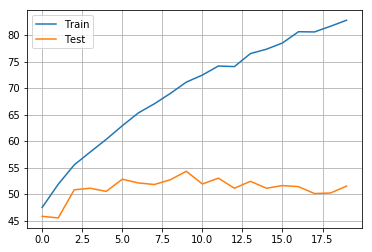

In [14]:
# 200 features 3 layers
plt.figure()
plt.plot(range(epochs), accuracy_train, label="Train")
plt.plot(range(epochs), accuracy_test, label="Test")
plt.legend()
plt.grid()
plt.show()

In [6]:
#traindataset = utils.TensorDataset(X_train, y_train)
#trainloader = utils.DataLoader(traindataset, batch_size=64, shuffle=True)

epochs = 10
accuracy_per_epoch = []

for cur_epoch in range(epochs):
    start = time.time()
    # Train
    for images, labels in iter(trainloader):
            
        optimizer.zero_grad()
        predicted = net.forward(images)
        loss = loss_func(predicted, labels)
        loss.backward()
        optimizer.step()
        
    # Test accuracy
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in iter(valloader):
            outputs = net.forward(images)
            _, predicted = torch.max(F.softmax(outputs).data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
                
    time_spent = time.time() - start
    start = time.time()
    accuracy_per_epoch.append(accuracy)
    
    print(f"Current epoch {cur_epoch}. Accuracy of the network: {accuracy}. Time spent: {time_spent}")

C:\Users\Oganes\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Current epoch 0. Accuracy of the network: 44.8. Time spent: 65.94373059272766
Current epoch 1. Accuracy of the network: 44.5. Time spent: 69.2902467250824
Current epoch 2. Accuracy of the network: 48.1. Time spent: 73.7737467288971
Current epoch 3. Accuracy of the network: 50.1. Time spent: 76.23479843139648
Current epoch 4. Accuracy of the network: 50.6. Time spent: 73.8637022972107
Current epoch 5. Accuracy of the network: 50.3. Time spent: 72.9415111541748


KeyboardInterrupt: 

After training, the model should be saved to be tested on the test dataset or to be used in a real-life application. To save a model in pytorch:

In [ ]:
torch.save(net.state_dict(), 'model.ckpt')

To load a pretrained model:

In [ ]:
checkpoint = torch.load("PATH_TO_SAVED_MODEL")
net.load_state_dict(checkpoint)